In [1]:
import os
import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state

import functools

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


data_dir = "./data"
device = jax.devices('cpu')[0]

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : TFRT_CPU_0


In [41]:
def z_meas_to_binary(line: str) -> np.ndarray:
    binary_array = [c == "Z" for c in line.strip()]
    return np.array(binary_array, dtype=np.float32).reshape(-1)

data_file = os.path.join(data_dir, "w_vanilla_20_20000.txt")

with open(data_file) as f:
    data = np.stack([z_meas_to_binary(l) for l in f])

print(f"Loaded {len(data)} samples, each of length {data.shape[1]} into numpy array of type {data.dtype}.")

num_train_samples = 20_000
rng = PRNGKey(0)

data_subset = jax.random.choice(rng, data, (num_train_samples,), replace=False)

print(f"Subset shape: {data_subset.shape}")

Loaded 20000 samples, each of length 20 into numpy array of type float32.
Subset shape: (20000, 20)


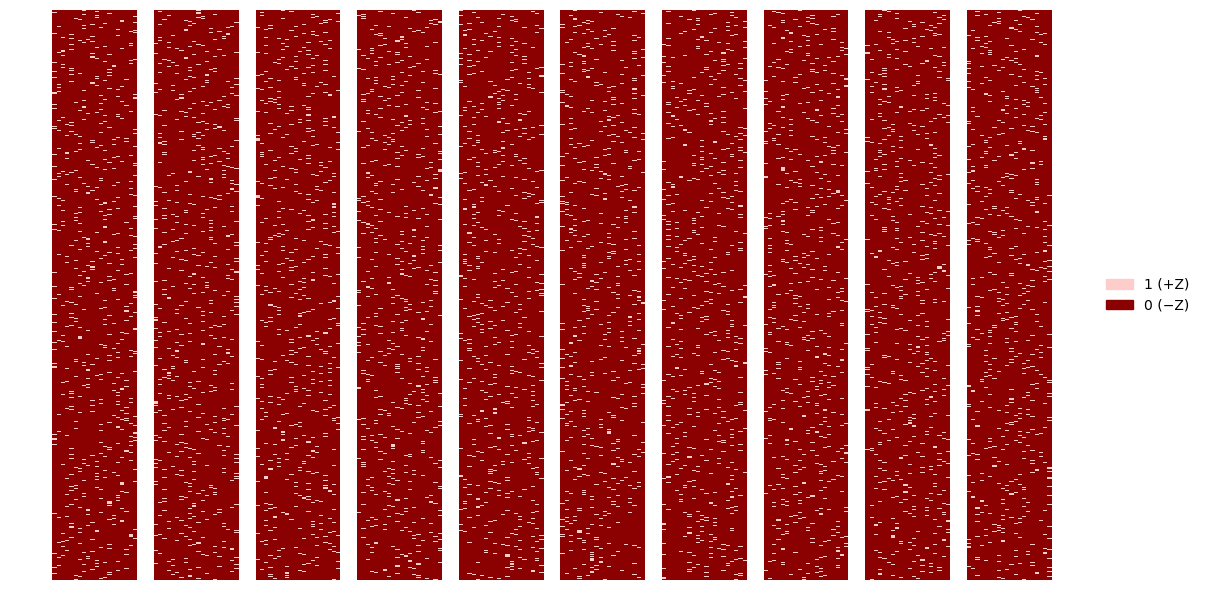

In [42]:
cols = 10
rows = data_subset.shape[0] // cols
panel_width = data_subset.shape[1]
spacer = 4
left_padding = 10
right_padding = 10

canvas_width = (left_padding + cols * panel_width + (cols - 1) * spacer + right_padding)

bright_red = "darkred"
dark_red = "#ffcccc"
flip_red_cmap = ListedColormap([bright_red, dark_red])
flip_red_cmap.set_bad("white")

canvas = np.full((rows, canvas_width), np.nan, dtype=np.float32)
for i in range(cols):
    start_x = left_padding + i * (panel_width + spacer)
    block = data_subset[i * rows:(i + 1) * rows, :]
    canvas[:, start_x:start_x + panel_width] = block

plt.figure(figsize=(12, 6))
img = plt.imshow(canvas, cmap=flip_red_cmap, interpolation='nearest', aspect='auto')
plt.axis('off')

dark_patch = mpatches.Patch(color=dark_red, label="1 (+Z)")
bright_patch = mpatches.Patch(color=bright_red, label="0 (−Z)")
plt.legend(
    handles=[dark_patch, bright_patch],
    loc="center right",
    bbox_to_anchor=(1.1, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()

In [63]:
# get rel frequency of up-spin on each site
rel_freq = data_subset.mean(0)
rel_freq

Array([0.0508 , 0.0488 , 0.0493 , 0.04755, 0.05205, 0.05125, 0.0463 ,
       0.0481 , 0.05075, 0.0512 , 0.0495 , 0.05305, 0.05085, 0.0501 ,
       0.049  , 0.0502 , 0.05075, 0.05025, 0.051  , 0.0492 ],      dtype=float32)

In [43]:
class DataLoader:
    def __init__(self, dataset, batch_size=128, shuffle=True, drop_last=False):
        self.x         = dataset
        self.bs        = batch_size
        self.shuffle   = shuffle
        self.drop_last = drop_last

        n_samples = len(self.x)
        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, n_samples, batch_size)
            if not drop_last or i + batch_size <= n_samples
        ]

    def __iter__(self):
        order = np.arange(len(self.x))
        if self.shuffle:
            np.random.shuffle(order)
        for s, e in self.idx_slices:
            yield self.x[order[s:e]]

    def __len__(self):
        return len(self.idx_slices)

In [44]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1

    @nn.compact
    def __call__(self, data_batch: jnp.ndarray, v_persistent: jnp.ndarray, rng: PRNGKey) -> (jnp.ndarray, jnp.ndarray):
        # in flax, __call__ is the main computation to be differentiated.

        # initialize parameters in @nn.compact style:
        W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        b = self.param("b", nn.initializers.zeros,        (self.n_visible,))
        c = self.param("c", nn.initializers.zeros,        (self.n_hidden,))
        params = {"W": W, "b": b, "c": c}

        # gibbs sampling only refines the fantasy particles, we are actually not interested in the gradients
        v_k, key = self._gibbs_sample(params, v_persistent, rng, k=self.k)
        v_k = jax.lax.stop_gradient(v_k)

        # we are interested in the gradients of the free energy w.r.t. the parameters
        free_energy_data  = self._free_energy(params, data_batch)
        free_energy_model = self._free_energy(params, v_k)

        pcd_loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)
        # since this is a pcd loss function, we also return the updated fantasy particles. and we also pass through the key
        # since JAX’s tree utilities flatten nested tuples we need to wrap the auxiliary variables in a container
        aux_vars = {"v_persistent": v_k, "key": key}

        return pcd_loss, aux_vars

    @staticmethod
    def _free_energy(params, v):
        W, b, c = params["W"], params["b"], params["c"]

        visible_term = jnp.dot(v, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    @staticmethod
    def _gibbs_step(i, state, params, T=1.0):
        v, key = state
        W, b, c = params["W"], params["b"], params["c"]

        # splitting generates different random numbers for each step, one of them is passed on
        key, h_key, v_key = jax.random.split(key, 3)

        h_logits = (v @ W + c) / T
        h_probs = jax.nn.sigmoid(h_logits)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_logits = (h @ W.T + b) / T
        v_probs = jax.nn.sigmoid(v_logits)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)
        return v, key

    @staticmethod
    def _gibbs_sample(params, v_init, rng, k=1, T=1.0):
        # the fori_loop enables JIT compilation of loops. It basically unrolls the loop over the fixed length k.

        body_fun = lambda i, state: RBM._gibbs_step(i, state, params, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_init, rng))
        return v_final, key

    @staticmethod
    def _annealing_step(i, state, params, T_schedule):
        v, rng = state
        T = T_schedule[i]
        # Perform one Gibbs step using the current temperature T.
        # Note: _gibbs_sample already handles k=1 and T
        v_next, rng_next = RBM._gibbs_sample(params, v, rng, k=1, T=T)
        return (v_next, rng_next)

    # the nowrap attribute basically tells JAX to not do the magic wrapping, which injects the params argument
    @nn.nowrap
    def generate(self, params: dict, n_samples: int, T_schedule: jnp.ndarray, rng: PRNGKey) -> jnp.ndarray:

        # get the initial state and perform initial key splitting
        rng, init_key = jax.random.split(rng)
        v = jax.random.bernoulli(init_key, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)
        init_state = (v, rng)

        body_fun = lambda i, state: RBM._gibbs_step(i, state, params, T_schedule[i])

        # the fori_loop is still required, since this function will also be JIT-compiled
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), body_fun, init_state)
        return v_final

In [45]:
class RBMTrainState(train_state.TrainState):
    """
    A value object bundling parameters and optimizer state for training.
    It has a few pre-defined fields to be used in the training loop.
    Since it is immutable, the training function needs to return a new instance after each update step.
    """
    pass


@functools.partial(jax.jit)
def train_step(state: RBMTrainState, data_batch: jnp.ndarray, v_persistent: jnp.ndarray, key: PRNGKey):

    # only the 'params' argument remains a variable to be differentiated
    pcd_loss_fn = lambda params: state.apply_fn({'params': params}, data_batch, v_persistent, key)

    # since our pc_loss_fn also returns the updated fantasy particles, we need to use has_aux=True
    value_and_grad_fn = jax.value_and_grad(pcd_loss_fn, has_aux=True)
    (pcd_loss, aux_vars), pdc_loss_grads = value_and_grad_fn(state.params)

    # apply the gradients to the state, this actually updates the optimizer state
    new_state = state.apply_gradients(grads=pdc_loss_grads)
    v_persistent = aux_vars["v_persistent"]
    key = aux_vars["key"]

    return new_state, pcd_loss, v_persistent, key


def train_rbm(state: RBMTrainState, train_loader, num_epochs: int, rng: PRNGKey, pcd_reset: int = 5, scheduler=None):
    metrics = {}

    for epoch in range(num_epochs):
        total_loss = 0.0
        batch_count = 0

        for batch_idx, data in enumerate(train_loader):

            if batch_idx % pcd_reset == 0:
                rng, subkey = jax.random.split(rng)
                v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=data.shape).astype(jnp.float32)

            state, loss, v_persistent, rng = train_step(state, data, v_persistent, rng)
            total_loss += loss
            batch_count += 1

        avg_loss = total_loss / len(train_loader)
        metrics[epoch] = {"free_energy_loss": float(avg_loss)}
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {avg_loss:.4f}")

    return state, metrics, rng

In [70]:
# ACTUAL TRAINING
batch_size    = 128
visible_units = 20
hidden_units  = 20
k_steps       = 1
lr            = 1e-2
num_epochs    = 300
pcd_reset     = None        # reset persistent chain every N batches
lr_decay      = 0.95      # not used explicitly here


# start of our random key-chain, it will be updated by regular splits (typically at each bernoulli sampling)
rng = PRNGKey(42)

# instantiate the optimizer and the RBM
train_loader = DataLoader(data_subset, batch_size=batch_size, shuffle=True)

optimizer = optax.adam(learning_rate=lr)
rbm = RBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps)

# initialize RBM parameters and create the training state
dummy_batch = data_subset[:batch_size]
rng, subkey = jax.random.split(rng)
v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=dummy_batch.shape).astype(jnp.float32)
params = rbm.init(rng, dummy_batch, v_persistent, rng)['params']

#p = 1/20
#init_b = np.full((20,), np.log(p/(1-p)), dtype=np.float32)
#params['b'] = jnp.array(init_b)


state = RBMTrainState.create(apply_fn=rbm.apply, params=params, tx=optimizer)

state, metrics, rng = train_rbm(state, train_loader, num_epochs, rng)

Epoch [1/300] - Free Energy Loss: -2.5998
Epoch [2/300] - Free Energy Loss: -0.2395
Epoch [3/300] - Free Energy Loss: -0.1700
Epoch [4/300] - Free Energy Loss: -0.1234
Epoch [5/300] - Free Energy Loss: -0.0711
Epoch [6/300] - Free Energy Loss: -0.0514
Epoch [7/300] - Free Energy Loss: -0.0504
Epoch [8/300] - Free Energy Loss: -0.0163
Epoch [9/300] - Free Energy Loss: -0.0195
Epoch [10/300] - Free Energy Loss: -0.0318
Epoch [11/300] - Free Energy Loss: 0.0031
Epoch [12/300] - Free Energy Loss: -0.0034
Epoch [13/300] - Free Energy Loss: 0.0073
Epoch [14/300] - Free Energy Loss: 0.0049
Epoch [15/300] - Free Energy Loss: 0.0155
Epoch [16/300] - Free Energy Loss: -0.0056
Epoch [17/300] - Free Energy Loss: 0.0044
Epoch [18/300] - Free Energy Loss: 0.0224
Epoch [19/300] - Free Energy Loss: -0.0034
Epoch [20/300] - Free Energy Loss: 0.0327
Epoch [21/300] - Free Energy Loss: 0.0107
Epoch [22/300] - Free Energy Loss: 0.0184
Epoch [23/300] - Free Energy Loss: 0.0307
Epoch [24/300] - Free Energy L

Text(0, 0.5, 'Free Energy Loss')

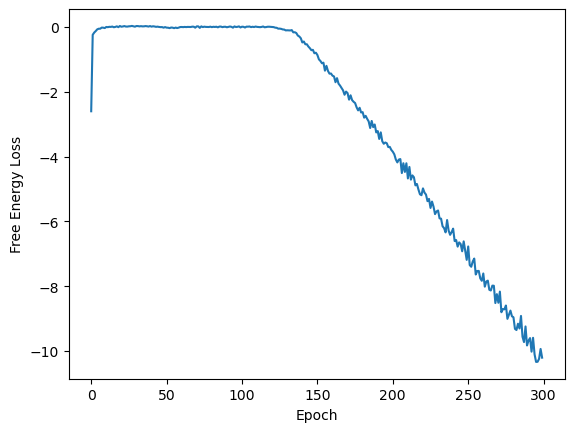

In [71]:
plt.plot([metrics[epoch]['free_energy_loss'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

In [84]:
samples = rbm.generate(state.params,
                       n_samples=10_000,
                       T_schedule=jnp.ones(200) * 1.2,
                       rng=rng)
rel_freq = samples.mean(0)
rel_freq

Array([0.0635, 0.    , 0.0621, 0.0483, 0.0636, 0.06  , 0.    , 0.    ,
       0.0649, 0.058 , 0.0519, 0.0671, 0.0581, 0.0615, 0.0501, 0.0478,
       0.055 , 0.0648, 0.0658, 0.0575], dtype=float32)

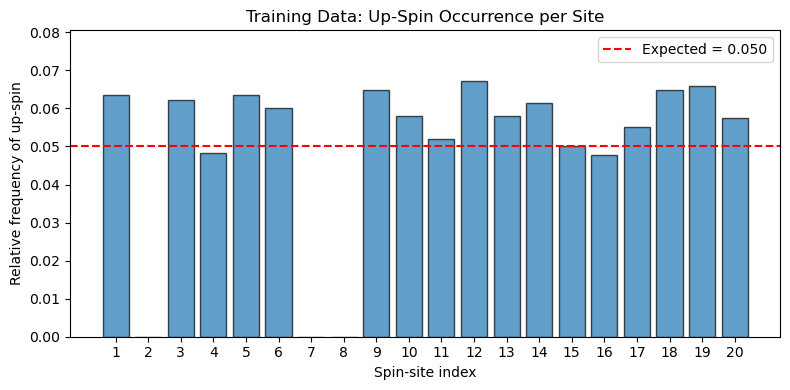

In [85]:
fig, ax = plt.subplots(figsize=(8,4))
sites = np.arange(1, visible_units+1)
ax.bar(sites, rel_freq, width=0.8, edgecolor='black', alpha=0.7)
ax.axhline(1/visible_units, color='red', linestyle='--', label=f'Expected = {1/visible_units:.3f}')

ax.set_xlabel('Spin‐site index')
ax.set_ylabel('Relative frequency of up‐spin')
ax.set_title('Training Data: Up‐Spin Occurrence per Site')
ax.set_xticks(sites)
ax.set_ylim(0, rel_freq.max()*1.2)

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()